In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import multivariate_normal as mvnorm 

In [2]:
# get the data
url = 'http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat'
df_origin = pd.read_csv(url, encoding="latin1",skiprows=20, sep="\s+")

In [3]:
# normalize it
scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(df_origin)
df = scaler.transform(df_origin)
df_later = df.copy()

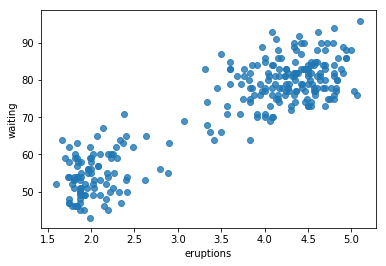

In [4]:
# Visualize data-set
sns.regplot(x=df_origin["eruptions"], y=df_origin["waiting"], fit_reg=False)
plt.show()

In [5]:
def generate_init_parameters(k):
    mus = []
    for _ in range(k):
        mus.append(np.random.rand(2) * np.random.uniform(-2, 2))
    pis = np.random.rand(k)
    pis = pis / sum(pis) # so that pis add up to 1
    sigmas = []
    for _ in range(k):
        sigmas.append(np.random.uniform(0,2) * np.identity(2))
    return np.array(mus), np.asarray(sigmas), pis

In [6]:
def get_responsibilities(mus, sigmas, pis, x):
    n = x.shape[0]
    k = len(pis)
    resp = np.zeros((k,n))
    for i in range(len(mus)):
        for j in range(len(x)):
            resp[i,j] = pis[i] * mvnorm.pdf(x=x[j], mean=mus[i], cov=sigmas[i])
            
    return resp / sum(resp)

In [7]:
def update_parameters(resp, df, mus):
    n_col = df.shape[1]
    n_row = df.shape[0]
    n_clusters = len(resp)
    
    # update pis
    pis = np.zeros(n_clusters)
    for i in range(n_clusters):
        pis[i] = sum(resp[i]) / n_row
    
    # update mus
    mus = np.zeros((n_clusters, n_col))
    for i in range(n_clusters):
        for j in range(n_row):
            mus[i] += resp[i, j] * df[j]
        mus[i] /= resp[i, :].sum()
    
    # update sigmas
    sigmas = np.zeros((n_clusters, n_col, n_col))
    for i in range(n_clusters):
        for j in range(n_row):
            ys = np.reshape(df[j] - mus[i], (2,1))
            sigmas[i] += resp[i,j] * np.dot(ys, ys.T)
        sigmas[i] /= resp[i,:].sum()
    
    return mus, sigmas, pis

In [28]:
def get_log_likelihood(pis, sigmas, mus, df):
    n_col = df.shape[1]
    n_row = df.shape[0]
    n_clusters = len(mus)
    log_ll = 0.0
    
    
    for i in range(n_row):
        ll = 0
        for j in range(n_clusters):
            if not is_pos_sem_def(sigmas[j]):
                # add some noise
                sigmas[j] = sigmas[j] + np.identity(n_col)*0.1   
            ll += pis[j] * mvnorm(mus[j], sigmas[j]).pdf(df[i])
        log_ll += np.log(ll)
    
    return log_ll

In [29]:
def is_pos_sem_def(x):
    return np.all(np.linalg.eigvals(x) >= 0)

In [30]:
def EM(df,k=2, max_iter=1000):
    old_ll = -9999
    n = 0
    best_ll = -9999
    intermediate_ll = -9999
    
    best_sigmas = np.zeros((k, df.shape[1], df.shape[1]))
    best_mus = np.zeros((k, df.shape[1]))
    best_pis = np.zeros(k)
    best_resp = np.zeros((k, df.shape[0]))
    
    while n < max_iter:
        mus, sigmas, pis = generate_init_parameters(k)
        resp = get_responsibilities(mus, sigmas, pis, df)
        mus, sigmas, pis = update_parameters(df=df, resp=resp, mus=mus)
        
        
        ll_new = get_log_likelihood(pis, sigmas, mus, df)
        
        if(ll_new > best_ll):
            if(np.abs(ll_new - best_ll) < 0.05):
                return mus, sigmas, resp, ll_new
            
            best_ll = ll_new
            best_sigmas = sigmas
            best_mus = mus
            best_resp = resp
        
        
        if(np.abs(ll_new - old_ll) < 0.05):
            return best_mus, best_sigmas, best_resp, ll_new
        
        old_ll = ll_new
        if(n%100 == 0):
            print("{} iterations done".format(n))
            print("Current best ll: {}".format(best_ll))
#             if(np.abs(intermediate_ll - best_ll) < 5):
#                 return best_mus, best_sigmas, best_resp, best_ll
#             intermediate_ll = best_ll
        n+=1
    return best_mus, best_sigmas, best_resp, ll_new

In [31]:
def get_data_label(resp):
    y = np.zeros(resp.shape[1])
    for i in range(resp.shape[1]):
        resp_vals = []
        for j in range(len(resp)):
            resp_vals.append(resp[j][i])
        y[i] = np.argmax(resp_vals)
    return y

In [32]:
mus, sigmas, resp, likelihood = EM(df_later, k=2, max_iter=1000)

0 iterations done
Current best ll: -544.0091550008513


In [33]:
# setup dataframe for visualization
x = pd.DataFrame(df_later[:,0])
y = pd.DataFrame(df_later[:,1])
label = pd.DataFrame(get_data_label(resp))
df = pd.concat([x, y, label], axis=1)
mu_df = pd.DataFrame(mus)
mu_df.columns = ["x", "y"]

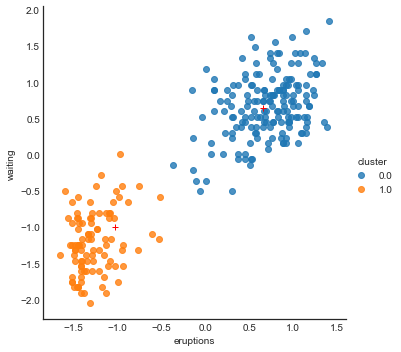

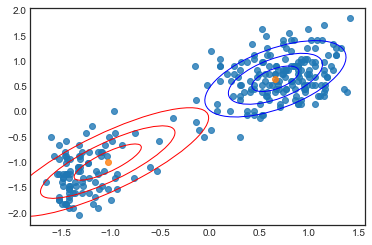

In [34]:
from matplotlib.patches import Ellipse
sns.set_style("white")
df.columns = ["eruptions", "waiting", "cluster"]
sns.lmplot(data=df, x="eruptions", y="waiting", hue="cluster", fit_reg=False, sharex=True, sharey=True)
# sns.lmplot(data=mu_df, x="x", y="y", fit_reg=False, sharex=True, sharey=True)
plt.plot(mu_df.x, mu_df.y, "r+")
plt.show()

sns.regplot(x=x, y=y, fit_reg=False)
sns.regplot(x=mus[:,0], y=mus[:,1], fit_reg=False)
#how to ellipse?
colors = ["b", "r", "y", "m", "c", ]
ax = plt.subplot()
for i in range(len(sigmas)):
    eigenval, eigenvec = np.linalg.eig(sigmas[i])
    eigenval = np.sqrt(eigenval)
    angle = np.rad2deg(np.arccos(eigenvec[0,0]))
    ellipse = Ellipse(xy=mus[i], width=eigenval[0], height=eigenval[1], angle=angle, fill=False, color=colors[i])
    ellipse_std = Ellipse(xy=mus[i], width=eigenval[0]*2, height=eigenval[1]*2, angle=angle, fill=False, color=colors[i])
    ellipse_2_std = Ellipse(xy=mus[i], width=eigenval[0]*3, height=eigenval[1]*3, angle=angle, fill=False, color=colors[i])
    ax.add_artist(ellipse)
    ax.add_artist(ellipse_std)
    ax.add_artist(ellipse_2_std)



plt.show()


0 iterations done
Current best ll: -544.9934804976514
0 iterations done
Current best ll: -556.7889720955069
0 iterations done
Current best ll: -550.7000872298996
0 iterations done
Current best ll: -496.30985383711965
0 iterations done
Current best ll: -384.2569728880471
100 iterations done
Current best ll: -384.2569728880471
200 iterations done
Current best ll: -384.2569728880471
300 iterations done
Current best ll: -384.2569728880471
400 iterations done
Current best ll: -384.2569728880471
500 iterations done
Current best ll: -384.2569728880471
0 iterations done
Current best ll: -497.46738562846457
100 iterations done
Current best ll: -379.1368258435744
200 iterations done
Current best ll: -379.1368258435744
300 iterations done
Current best ll: -379.1368258435744
400 iterations done
Current best ll: -379.1368258435744
500 iterations done
Current best ll: -379.1368258435744
600 iterations done
Current best ll: -379.1368258435744
700 iterations done
Current best ll: -379.1368258435744
80

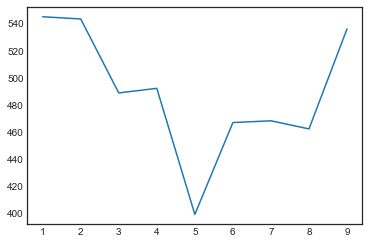

In [35]:
likelihoods = []
for k in range(1, 10, 1):
    a,b,c, ll = EM(df=df_later,k=k, max_iter=1000)
    likelihoods.append(ll)
    
plt.plot(np.arange(1,10,1), np.abs(likelihoods))
plt.show()

In [19]:
likelihoods

[-544.99348049765138,
 -544.95129960734437,
 -542.64476656787269,
 -543.75230012937243,
 -383.67964539146055]

In [ ]:
plt.show()

In [ ]:
# idk i would have expected an elbow-plot again, but this has to be fined tuned with the parameters above. 